In [2]:
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib . pyplot as plt

In [266]:
def inliers(points, center,  r, thresh_dis):
    low_thresh, high_thresh = r-thresh_dis, r+thresh_dis
    dis = np.sqrt((points[:, 0]-center[0])**2+(points[:, 1]-center[1])**2)
    indices = [i for i in range(0, len(points)) if low_thresh<=abs(dis[i])<=high_thresh]
    inl = np.array([list(points[i]) for i in indices])
    return inl

In [4]:
def circle_points(center, r):
    theta = np.linspace(0, 2*np.pi, 100)
    x = center[0] + r*np.cos(theta)
    y = center[1] + r*np.sin(theta)
    return (x, y)

In [259]:
def mean_absolute_error(points, center, r):
    g, f = center[0], center[1]
    dis = np.sqrt((points[:, 0]-g)**2+(points[:, 1]-f)**2)
    error = np.sum(abs(dis-r))/len(points)
    return error

In [531]:
def best_RANSAC(ran):
    max_inl_count = 0
    best_ran = [[[], []], [[], []], [], [], [[], []]]
    for i in range(0, len(ran[0][0])):
        if max_inl_count<len(ran[2][i]):
            max_inl_count = len(ran[2][i])
            for j in range(0, 5):
                if j==2 or j==3:
                    best_ran[j] = ran[j][i]
                else:
                    best_ran[j][0] = ran[j][0][i]
                    best_ran[j][1] = ran[j][1][i]
        elif max_inl_count==len(ran[2][i]):
            if (best_ran[3] > ran[3][i]):
                max_inl_count = len(ran[2][i])
            for j in range(0, 5):
                if j==2 or j==3:
                    best_ran[j] = ran[j][i]
                else:
                    best_ran[j][0] = ran[j][0][i]
                    best_ran[j][1] = ran[j][1][i]

    print('inlier count :',max_inl_count)
    return best_ran

In [518]:
def RANSAC(points, N, iterations, inlier_count, max_thresh, cand=0):
    max_r = (abs(points[:, 0].min())+abs(points[:, 0].max()))/2+5
    ran = [[[], []], [[], []], [], [], [[], []]]    #center-RANSAC, center-best, sample-RANSAC, sample-RANSAC, inliers-RANSAC, error-RANSAC, radius-RANSAC, radius-best
    for i in range(0, iterations):
        p1, p2, p3 = points[np.random.choice(points.shape[0], 3, replace=False), :]
        A = np.array([[2*p1[0], 2*p1[1], 1], [2*p2[0], 2*p2[1], 1], [2*p3[0], 2*p3[1], 1]])
        B = np.array([[p1[0]**2+p1[1]**2], [p2[0]**2+p2[1]**2], [p3[0]**2+p3[1]**2]])
        res = np.linalg.pinv(A) @ B
        g, f = res[0][0], res[1][0]
        r = np.sqrt(res[2]+g**2+f**2)
        if (r[0]>max_r):
            continue
        inlier_points = inliers(points, (g, f), r, max_thresh)
        if (inlier_count<=len(inlier_points)):
            if (cand==1):
                ran[0][0].append((g,f))
                ran[1][0].append(np.array([[p1[0], p1[1]], [p2[0], p2[1]], [p3[0], p3[1]]]))
                ran[2].append(inlier_points)
                error = mean_absolute_error(inlier_points, (g, f), r)
                ran[3].append(error)
                ran[4][0].append(r)
            if (cand==0):
                ran[0][1].append((g, f))
                ran[1][1].append(np.array([[p1[0], p1[1]], [p2[0], p2[1]], [p3[0], p3[1]]]))               
                ran[4][1].append(r)
                ran2 = RANSAC(inlier_points, len(inlier_points), 100, inlier_count, max_thresh, 1)
                for i in range(0, len(ran2[0][0])):
                    ran[0][0].append(ran2[0][0][i])
                    ran[0][1].append((g, f))
                    ran[1][0].append(ran2[1][0][i])
                    ran[1][1].append(np.array([[p1[0], p1[1]], [p2[0], p2[1]], [p3[0], p3[1]]]))
                    ran[2].append(ran2[2][i])
                    ran[3].append(ran2[3][i])
                    ran[4][0].append(ran2[4][0][i])
                    ran[4][1].append(r)
    return ran


inlier count : 24


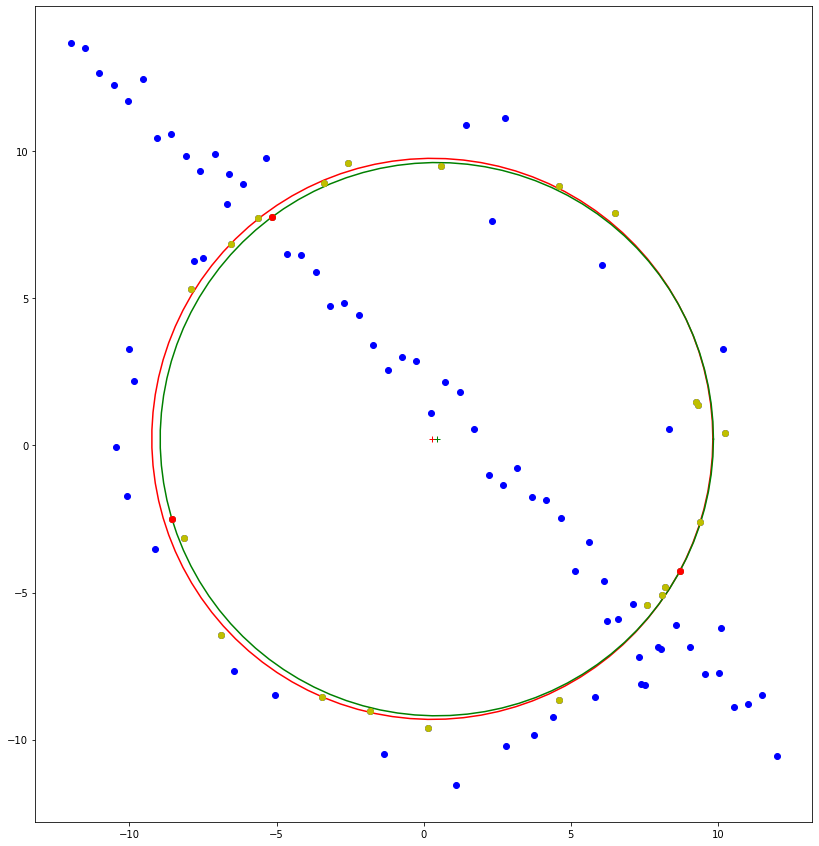

In [558]:
# np . random . seed ( 0 )
N = 100
half_n = N// 2
r = 10
s = r/16
t = np.random.uniform(0, 2*np.pi, half_n)
n = s*np.random.randn(half_n)
x, y = (r + n)*np.cos(t), (r + n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
X = np.vstack((X_circ, X_line))

X = X[np.argsort(X[:, 0])]

data = RANSAC(X, N, 100, 20, 0.5)
best_ran = best_RANSAC(data)
center_ran, center_best = best_ran[0][0], best_ran[0][1]
sample_ran, sample_best = best_ran[1][0], best_ran[1][1]
inlier_points = best_ran[2]
error = best_ran[3]
r_ran, r_best = best_ran[4][0], best_ran[4][1]
circle_ran = circle_points(center_ran, r_ran)
circle_best = circle_points(center_best, r_best)
fig, ax = plt.subplots(figsize=(15, 15))
ax.plot(X[:, 0], X[:, 1], 'bo')
ax.plot(center_ran[0], center_ran[1], 'r+')
ax.plot(circle_ran[0], circle_ran[1], 'r')
ax.plot(center_best[0], center_best[1], 'g+')
ax.plot(circle_best[0], circle_best[1], 'g')
ax.plot(inlier_points[:, 0], inlier_points[:, 1], 'yo')
ax.plot(sample_best[:, 0], sample_best[:, 1], 'ro')
ax.set_aspect('equal')

plt.show()